In [2]:
# -*- coding: utf-8 -*-
"""
Created on Sun Feb  4 14:07:39 2024

@author: Hugues-Edouard
"""

#Libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from yellowbrick.features import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer, InterclusterDistance

In [ ]:

### Data Importation

Data = pd.read_csv("surfing_csv.csv", sep=';')
print(Data.columns.tolist())

In [13]:
########################################## Mise en forme des données ###################################
qualitative_columns = [
    "board_adequate", "board_nose_shape", "board_tail_shape", "board_type",
    "manoeuvres_01_paddling", "manoeuvres_02_drop", "manoeuvres_03_straight_ahead", "manoeuvres_04_wall_riding",
    "manoeuvres_05_floater","manoeuvres_06_cut_back","manoeuvres_07_carve","manoeuvres_08_off_the_lip",
    "manoeuvres_09_tube","manoeuvres_10_air","performance_control","performance_ease_paddling",
    "performance_flotation","performance_hold","performance_passing_through","performance_stability",
    "performance_surf_speed","surfer_exercise_frequency","surfer_experience","surfer_style","surfer_gender","wave_shape"
]

#Création d'un Data Frame des valeurs à encoder
df_encoding = Data[qualitative_columns]

#Création d'un Data Frame des valeurs Digitales
df_digit = Data.drop(columns=qualitative_columns) 

#Mise à part de la colonnes "wave_height" pour le moment car compliqué à 
columns_to_drop = ["wave_height","Unnamed: 0"]
df_digit = df_digit.drop(columns=columns_to_drop) 

#Supprime la colonnes si elle contient des valeurs Nan supérieur à 50%
df_digit = df_digit.dropna(thresh=0.5*len(df_digit), axis=1)


#Gestion des valeurs des Nan
df_digit = df_digit.fillna(df_digit.mean())

#Pour df_encoding on remplace les valeurs Nan par la valeur "I don't know"
df_encoding = df_encoding.fillna("I don't know")



In [15]:
######################################## Standardisation et Encodage ###################################
#Encodage Ordinaire
encoder = OrdinalEncoder()
Data_encoder = encoder.fit_transform(df_encoding)
# Convertir le tableau NumPy en DataFrame pandas
Data_encoder_converti = pd.DataFrame(Data_encoder, columns=df_encoding.columns)


# Data standardization
# Creating the scaler instance
scaler = StandardScaler()
scaler.fit(df_digit)
df_scale = scaler.transform(df_digit) # standardise et créer le dfs standarsé les valeur
#sont centrées sur 0, l'algo fait [(variable-moyenne)/ecart-type]

# Créez un nouveau DataFrame pandas avec les données transformées
df_scaled = pd.DataFrame(df_scale, columns=df_digit.columns)



######################################################################################################
#On a maintenant nos deux tableau df_scaled et Data_encoder_converti
df_Processed = pd.concat([df_scaled, Data_encoder_converti], axis=1)


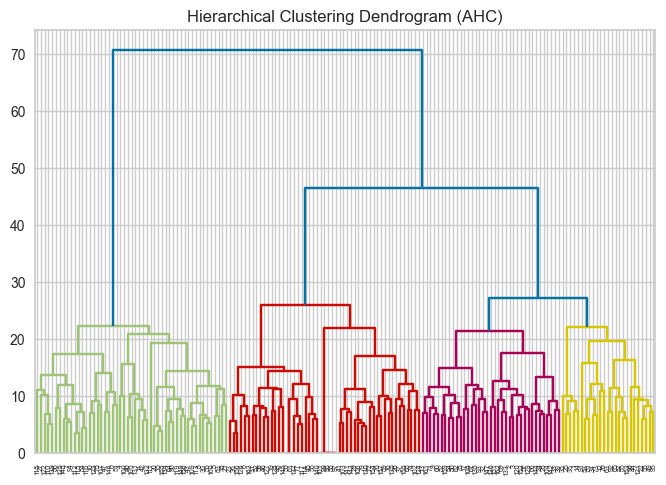

In [16]:
##################################################################
# Hierarchical Clustering with Agglomerative Hierarchical Clustering (AHC)
##################################################################

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster



# Generate the linkage matrix
Z = linkage(df_Processed, method='ward', metric='euclidean')

##############################  Dendrogram   ########################################
# Fine-Tuning (determine the optimal number of clusters)
# Display the dendrogram
plt.title("Hierarchical Clustering Dendrogram (AHC)")
dendrogram(Z, orientation='top', color_threshold=27)
plt.show()


In [ ]:

###############################   Inertia diagram  ##############################
#Identifie le premier grand saut d'inertie 
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(2, len(last) + 2)
plt.step(idxs, last_rev, c="black")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")

# Here, we visualize the scenario with 4 clusters
num_clusters = 4
plt.scatter(idxs[np.where(idxs==num_clusters)], last_rev[np.where(idxs==num_clusters)], c="red")
plt.axvline(idxs[np.where(idxs==num_clusters)], c="red")
plt.show()


# Creating 4 clusters by cutting at height t = 30
clusters_ahc = fcluster(Z, t=30, criterion='distance') #Attribu les cluster au data



#Récupérer les cluters
cluster1=df_Processed[clusters_ahc==1]
cluster2=df_Processed[clusters_ahc==2]
cluster3=df_Processed[clusters_ahc==3]
cluster4=df_Processed[clusters_ahc==4]


print ('cluster1\n',cluster1.describe())  #expliquer les clusters
print ('cluster2\n',cluster2.describe())
print ('cluster3\n',cluster3.describe())
print ('cluster4\n',cluster4.describe())

print ('cluster3\n',cluster3.mean())
print ('cluster4\n',cluster4.mean())


d:\Documents\Python\3.11.5\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Documents\Python\3.11.5\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Documents\Python\3.11.5\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Documents\Python\3.11.5\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the 

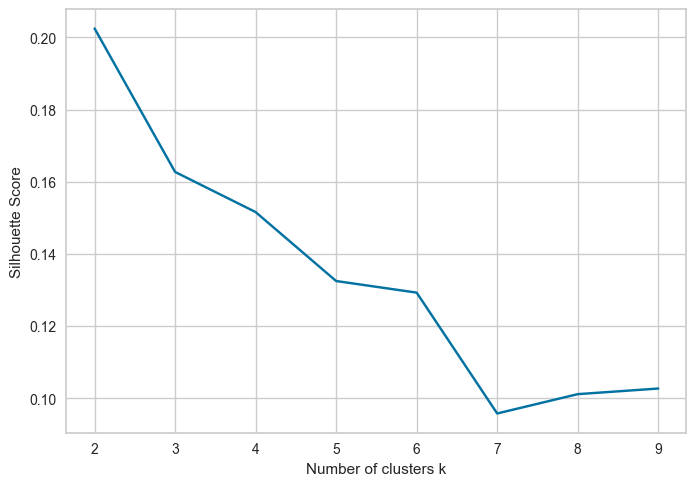

In [19]:
#############################################################
# Flat Clustering with KMeans
#############################################################
# KMeans model instantiation

model = KMeans()

# Fine-tuning the model to determine the optimal hyperparameters

# Manual fine-tuning tools

# Silhouette score for assessing cluster quality
from sklearn.metrics import silhouette_score
K = 10  # Maximum number of clusters to try
silhouette_scores = np.zeros(K-2)
for k in range(2, K):
    # Create a KMeans instance with k clusters
    model = KMeans(n_clusters=k, random_state=42)
    # Fit the model and predict the clusters
    model_labels = model.fit_predict(df_Processed)
    # Calculate the silhouette score and store it
    silhouette_scores[k-2] = silhouette_score(df_Processed, model_labels)

# Plot the silhouette scores for different numbers of clusters
plt.plot(range(2, K), silhouette_scores, 'b-')
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette Score")
plt.show()


d:\Documents\Python\3.11.5\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


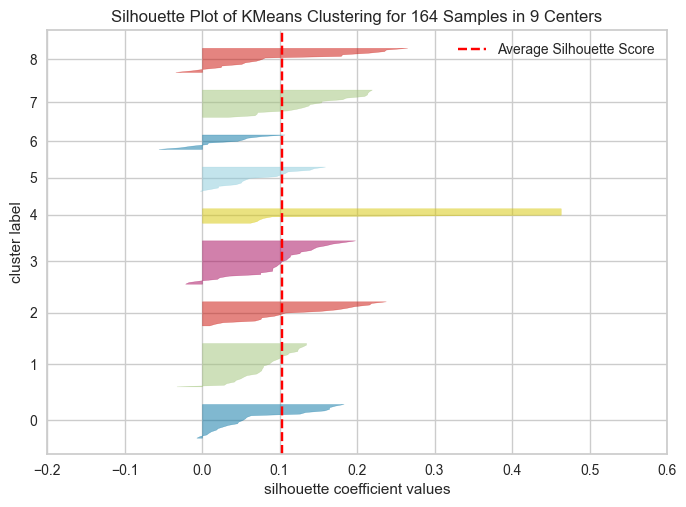

d:\Documents\Python\3.11.5\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Documents\Python\3.11.5\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Documents\Python\3.11.5\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Documents\Python\3.11.5\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the 

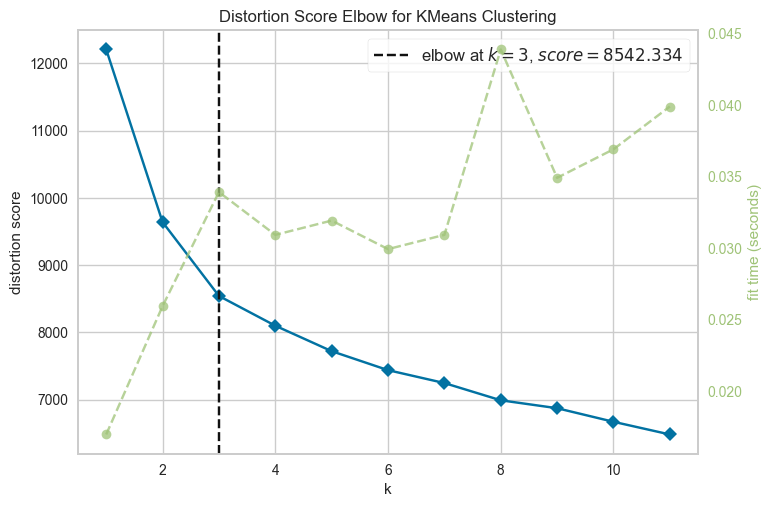

d:\Documents\Python\3.11.5\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
d:\Documents\Python\3.11.5\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


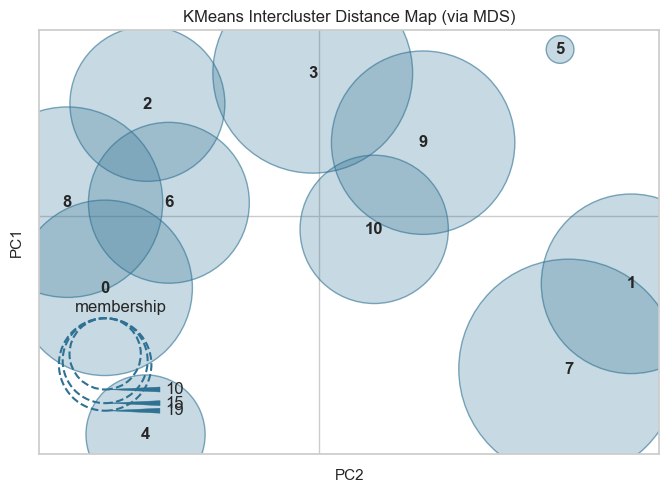

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [20]:
#################################   Silhouette   ########################################
# Selecting the best model using various indicators

# Silhouette Visualizer to visualize the silhouette score
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
# Fit the data to the visualizer
visualizer.fit(df_Processed)
# Render the figure
visualizer.show()


#Permetde trouver l'inetie intra class et de déterminer le nb de cluster
# KElbow Visualizer to find the elbow point
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 12))
# Fit the data to the visualizer
visualizer.fit(df_Processed)
# Render the figure
visualizer.show()

# Intercluster Distance Map to visualize the distance between clusters
visualizer = InterclusterDistance(model)
# Fit the data to the visualizer
visualizer.fit(df_Processed)
# Render the figure
visualizer.show()
